In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [124]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 20.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 8.3 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [127]:
data = pd.read_csv('TMU.csv')
data = data.drop("Unnamed: 0", axis = 1)
data = data.drop("CHR_NO", axis = 1)


mapping = {
    'Regular': 15,
    'Restlessness': 25,
    'Tachypneic (RR > 35 b/min)': 35,
    'Shallow': np.nan,
    'Prolonged exhalation': np.nan,
    'Splinting': np.nan,
    'Irregular': np.nan,
    'Discoordinate': np.nan,
    'Agonal': np.nan,
    'Cheyne-Stokes': np.nan,
    'Kussmaul': np.nan,
    'Accessory muscle use/retractions': np.nan
}

mimic_data = pd.read_csv('mimic_data_v2.csv')
mimic_data = mimic_data.drop('subject_id', axis= 1)
mimic_data['gender'] = mimic_data['gender'].map({'M': 0, 'F': 1})

mimic_data['bf'] = mimic_data['bf'].replace(mapping)

data.head(10)


,bf,bt,cv1,gc_1,gc_2,gc_3,mp,sp,mortality,age,gender
0,18.0,36.7,7.0,3,1,6.0,110.0,100.0,1,77,0
1,17.0,36.3,21.0,0,0,0.0,88.0,98.0,0,46,1
2,18.0,37.3,-1.0,4,5,6.0,88.0,97.0,1,72,1
3,18.0,36.3,-1.0,0,0,0.0,66.0,97.0,1,83,1
4,27.0,36.6,17.0,4,4,6.0,98.0,92.0,1,53,1
5,17.0,36.0,-1.0,4,5,6.0,60.0,98.0,0,56,1
6,17.0,35.8,-1.0,1,1,1.0,123.0,82.0,1,68,1
7,22.0,37.3,13.0,1,1,4.0,93.0,100.0,0,64,1
8,14.0,37.0,-1.0,4,5,6.0,67.0,100.0,0,55,1
9,15.0,36.2,-1.0,4,5,6.0,84.0,100.0,0,72,1


In [128]:
mimic_data.head()

,bf,bt,cv1,gc_1,gc_2,gc_3,mp,sp,age,gender,mortality
0,NaN,NaN,18.0,4.0,5.0,6.0,144.0,NaN,47,0,0
1,35.0,37.9,NaN,4.0,1.0,2.0,122.0,NaN,61,0,1
2,NaN,37.4,14.0,4.0,5.0,6.0,103.0,NaN,76,0,0
3,NaN,NaN,NaN,4.0,5.0,6.0,97.0,NaN,63,1,0
4,NaN,37.6,23.0,4.0,5.0,6.0,120.0,NaN,28,0,0


In [136]:
# Step 3: Preprocess Your Data
# Assuming 'target' is the binary target variable and all other columns are features
X = data.drop('mortality', axis=1)
y = data['mortality']


# Optional: Handle missing values if any
X.fillna(X.mean(), inplace=True)  # Example of filling missing values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

mX = mimic_data.drop('mortality', axis=1)
my = mimic_data['mortality']
mX['sp'].fillna(100,inplace = True)
mX.fillna(mX.mean(),inplace = True)

mX_train, mX_test, my_train, my_test = train_test_split(mX, my, test_size=0.1, random_state=42)

In [107]:
print(mX_train.shape)
print(mX_test.shape)

(76716, 10)
(8525, 10)


AttributeError: 'DataFrame' object has no attribute 'isnan'

In [63]:
len(data[data['mortality']==1])

2904

In [64]:
len(data[data['mortality']==0])

3507

In [135]:
# Create the XGBoost model


model = xgb.XGBClassifier( eval_metric='mlogloss')

# Train the model
model.fit(mX_train, my_train)

# Predict binary values on the test set
my_pred = model.predict(mX_test)

# Evaluate accuracy
accuracy = accuracy_score(my_test, my_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(confusion_matrix(my_test, my_pred))
print('Classification Report:')
print(classification_report(my_test, my_pred))

Accuracy: 0.92
Confusion Matrix:
[[7426  148]
 [ 560  391]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7574
           1       0.73      0.41      0.52       951

    accuracy                           0.92      8525
   macro avg       0.83      0.70      0.74      8525
weighted avg       0.91      0.92      0.91      8525



In [137]:
# Make predictions
clf = model
y_pred = clf.predict(X_test)

# Evaluate the model
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

forest = clf
importances = forest.feature_importances_
forest_importances = pd.Series(importances)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

custom_labels = ['bf', 'bt', 'cv1', 'gc_1', 
                 'gc_2', 'gc_3', 'mp', 'sp', 
                 'age', 'gender']


fig, ax = plt.subplots()
# Set the x-axis ticks and labels



forest_importances.plot.bar( ax=ax)
ax.set_xticks(np.arange(len(custom_labels)))  # Set positions of ticks
ax.set_xticklabels(custom_labels)              # Set custom labels
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Confusion Matrix:
[[196 152]
 [101 193]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       348
           1       0.56      0.66      0.60       294

    accuracy                           0.61       642
   macro avg       0.61      0.61      0.61       642
weighted avg       0.61      0.61      0.61       642



AttributeError: 'XGBClassifier' object has no attribute 'estimators_'

In [68]:
data.head()

,bf,bt,cv1,gc_1,gc_2,gc_3,mp,sp,mortality,age,gender
0,18.0,36.7,7.0,3,1,6.0,110.0,100.0,1,77,0
1,17.0,36.3,21.0,0,0,0.0,88.0,98.0,0,46,1
2,18.0,37.3,-1.0,4,5,6.0,88.0,97.0,1,72,1
3,18.0,36.3,-1.0,0,0,0.0,66.0,97.0,1,83,1
4,27.0,36.6,17.0,4,4,6.0,98.0,92.0,1,53,1


In [52]:
from sklearn.linear_model import LogisticRegression

# Train a logistic regression model
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear')
logistic_model.fit(X_train, y_train)

# Predict binary values on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.62
Confusion Matrix:
[[265  83]
 [161 133]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.76      0.68       348
           1       0.62      0.45      0.52       294

    accuracy                           0.62       642
   macro avg       0.62      0.61      0.60       642
weighted avg       0.62      0.62      0.61       642



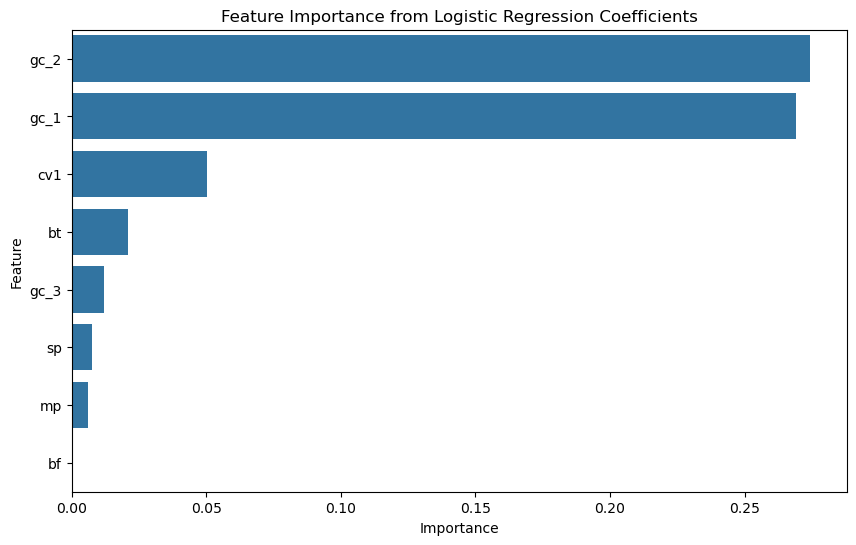

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Assuming X_train is your training data and y_train is the target
# logistic_model = LogisticRegression()
# logistic_model.fit(X_train, y_train)

# Get the feature names and their corresponding coefficients
feature_names = X_train.columns  # Replace with your feature names
coefficients = logistic_model.coef_.flatten()

# Create a dataframe with feature names and coefficients
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)  # Taking absolute value for importance
})

# Sort the dataframe by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Logistic Regression Coefficients')
plt.show()

In [121]:
# random forest

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
mX_train_resampled, my_train_resampled = smote.fit_resample(mX_train, my_train)

# Train a model on the resampled data
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(mX_train_resampled, my_train_resampled)

# Make predictions
my_pred = clf.predict(mX_test)

# Evaluate the model
print('Confusion Matrix:')
print(confusion_matrix(my_test, my_pred))
print('Classification Report:')
print(classification_report(my_test, my_pred))

Confusion Matrix:
[[7046  528]
 [ 465  486]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7574
           1       0.48      0.51      0.49       951

    accuracy                           0.88      8525
   macro avg       0.71      0.72      0.71      8525
weighted avg       0.89      0.88      0.89      8525



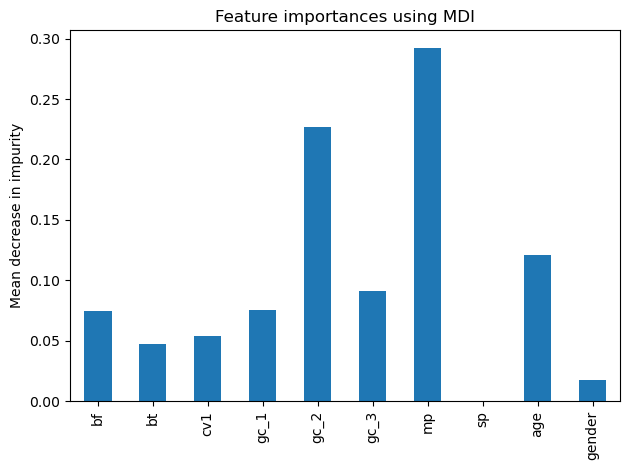

In [122]:
forest = clf
importances = forest.feature_importances_
forest_importances = pd.Series(importances)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

custom_labels = ['bf', 'bt', 'cv1', 'gc_1', 
                 'gc_2', 'gc_3', 'mp', 'sp', 
                 'age', 'gender']


fig, ax = plt.subplots()
# Set the x-axis ticks and labels



forest_importances.plot.bar( ax=ax)
ax.set_xticks(np.arange(len(custom_labels)))  # Set positions of ticks
ax.set_xticklabels(custom_labels)              # Set custom labels
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Confusion Matrix:
[[124 224]
 [ 58 236]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.36      0.47       348
           1       0.51      0.80      0.63       294

    accuracy                           0.56       642
   macro avg       0.60      0.58      0.55       642
weighted avg       0.60      0.56      0.54       642



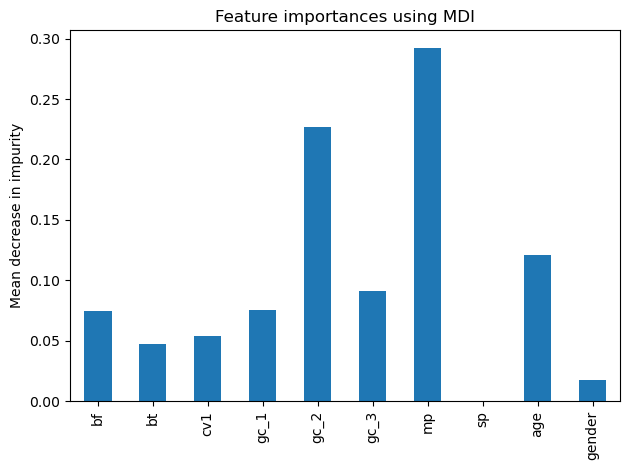

In [123]:

y_pred = clf.predict(X_test)

# Evaluate the model
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

forest = clf
importances = forest.feature_importances_
forest_importances = pd.Series(importances)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

custom_labels = ['bf', 'bt', 'cv1', 'gc_1', 
                 'gc_2', 'gc_3', 'mp', 'sp', 
                 'age', 'gender']


fig, ax = plt.subplots()
# Set the x-axis ticks and labels



forest_importances.plot.bar( ax=ax)
ax.set_xticks(np.arange(len(custom_labels)))  # Set positions of ticks
ax.set_xticklabels(custom_labels)              # Set custom labels
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()